In [1]:
# DSC 550
# Milestone 5
# Matthew Fikes
# 5/20/21

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, fbeta_score, precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

In [23]:
# set seed so samples are the same for outputs
np.random.seed(42)

In [24]:
df = pd.read_excel('retention_output.xls')

In [25]:
#Removing vields based on Milestone 4 analysis
empty_fields = ['HEH_ADMIT','MIDTERM','HISPANIC_ORIGIN']
zero_fields = ['UPPER_CRED','GRAD_CRED','SS_DEVELOPMNTL']
irrev_fields = ['VISA','PROGRAM','AGE','RETAINED_1YEAR','PIDM','CITY','TERM','COUNTRY','COUNTY','CEEB','MILITARY_STATUS','NATIVE_LANG','STATE','TUITION_RATE','HEH_ORIGINAL','SS_AUDITED','SS_SENIOR_AUD','XFER_CRED','XREG_TRANSFER','HS_GRAD']
redundant_fields = ['LOWER_CRED']
droplist = empty_fields + zero_fields + irrev_fields + redundant_fields
df = df.drop(droplist,axis=1)

In [26]:
# function to convert GPA on 100 point scale to 4.0 scale to match existing data
# based on code I wrote originally in VBA

def fix_GPA(HS_GPA):
    
    gpa_2_switch = {
        '4':'9',
        '3':'8',
        '2':'7',
        '1':'6',
        '0':'5',
        '9':'4',
        '8':'3',
        '7':'2',
        '6':'1',
        '5':'0'      
    }
    
    if float(HS_GPA) <=4:
        gpa = HS_GPA
        return gpa
    else: 
        if HS_GPA >= 95:
            gpa = 4.00
            return gpa
        elif HS_GPA < 56:
            gpa = 0.00
            return gpa
        else:
            temp_str = str("{0:.2f}".format(HS_GPA))
            print(temp_str[:2])
            gpa_2 = gpa_2_switch.get(temp_str[1])
            if int(temp_str[:2]) in range(85,95):
                gpa_1 = '3'
                
            elif int(temp_str[:2]) in range(75,85):
                gpa_1 = '2'
                
            elif int(temp_str[:2]) in range(65,75):
                gpa_1 = '1'
                
            else:
                gpa_1 = '0'
               
            
            gpa_3 = temp_str[4]           
            gpa_str = ("{0}.{1}{2}".format(gpa_1,gpa_2,gpa_3))            
            gpa = float(gpa_str)
         
            
    return gpa

In [27]:
# fix invalid HS_GPA values, save into HS_GRADE and drop the original
df['HS_GRADE']= df['HS_GPA'].dropna().apply(fix_GPA)
df = df.drop('HS_GPA',axis=1)

80
68
82
82
78
78
84
85
85
83
84
84
85
87
70
79
79
82
79
85
78
85
85
77
83
71
73
82
93
86
79
88
87
91
79
77
85
88
83
88
81
85
77
87
81
90
78
88
81
91
81
80
79
74
76
94
87
79
88
92
79
86
85
72
71
79
82
87
80
75
75
71
69
74
77
94
77
80
77
78
89
87
78
77
76
78
83
77
84
93
81
87
79
76
89
90
81
78
84
79
83
81
93
73
74
77
81
91
86
87
78
78
80
78
87
89
88
66
79
92
85
78
66
73
85
89
74
83
82
88
82
87
86
84
78
82
79
86
87
86
86
70
94
73
81
75
81
74
82
84
89
80
82
89
83
82
82
84
80
83
73
71
79
90
90
91
91
92
85
82
69
88
85
73
76
79
87
86
79
92
89
79
78
84
93
81
85
78
72
90
86
86
78
83
71
91
71
77
67
81
92
74
82
83
92
89
75
79
86
86
87
90
83
90
81
93
76
78
85
83
84
89
85
90
93
86
87
78
90
86
94
90
80
88
92
87
94
84
88
82
79
94
93
85
89
81
90
91
84
86
84
90
85
81
86
87
86
90
83
90
91
85
88
87
88
84
89
88
90
87
91
90
81
88
82
92
81
90
89
88
82
74
91
87
82
91
84
87
76
90
90
84
85
86
90
85
88
85
91
83
93
87
82
77
92
94
81
88
80
89
72
94
82
82
82
87
84
92
87
80
78
75
89
86
90
79
87
90
83
84
82
86
79
7

In [57]:
# add more samples for testing
#df = df.sample(frac=3, replace=True, random_state=1)

For making the most of the resulting classifications I will split the dataset into data obtained when a student applies and then the full set available by the end of term. This may allow us to find intervention methods to keep students from dropping out even before the semester finishes.

In [58]:
# make a list of early-obtained features
early_vars = ['ZIP','ADM_STATUS','PELL','TAP','HAS_KIDS','MOM_ED','DAD_ED','HS_GRADE','HEH','AWD_LVL','EDUCATION_GOAL','HS_STATUS','ETHNICITY','HDEG']
early_df = df[early_vars]
late_df = df

In [59]:
df.isna().any()

ZIP               False
ETHNICITY         False
HDEG               True
ADM_STATUS        False
HEH               False
HS_STATUS          True
A_CRED            False
AWD_LVL           False
T_CRED            False
GPA               False
PELL              False
TAP               False
HOUSING           False
EDUCATION_GOAL    False
SUB_CAMPUS        False
SS_REMEDIAL       False
SS_REMEDIAL_CE    False
RETAINED_1SEM     False
HAS_KIDS           True
DISADVANTAGED      True
FINAL              True
MOM_ED             True
DAD_ED             True
REPEAT_IND        False
HS_GRADE           True
dtype: bool

In [60]:
# Take categorical columns and recode them to numbers for both sets
cat_cols_e = ['ADM_STATUS','MOM_ED','DAD_ED','HEH','AWD_LVL','EDUCATION_GOAL','HS_STATUS','ETHNICITY','HDEG']
cat_cols_l = ['ADM_STATUS','MOM_ED','DAD_ED','SUB_CAMPUS','DISADVANTAGED','FINAL','HEH','AWD_LVL','EDUCATION_GOAL','HS_STATUS','ETHNICITY','HDEG']

data_cat_e = early_df[cat_cols_e]  
data_cat_l = late_df[cat_cols_l]

data_cat_dummies_e=pd.get_dummies(data_cat_e)
data_cat_dummies_l=pd.get_dummies(data_cat_l)

cat_cols_l.append('RETAINED_1SEM')

df_features_e = early_df.drop(columns=cat_cols_e)
df_features_l = late_df.drop(columns=cat_cols_l)


With the variables fixed, NA values now need to be addressed for the model to function properly. While I could just drop any columns with missing values those might provide information for the model. Instead I will use Multivariate Imputation by Chained Equations (MICE). This method will treat each missing value as the target in a linear regression. The method can create multiple imputations to account for statistical uncertainty but at this point I am using the results of a single imputation.

In [61]:
# use MICE to impute missing category data
imp_e = sm.MICEData(data_cat_dummies_e)
imp_e.update_all()

imp_l = sm.MICEData(data_cat_dummies_l)
imp_l.update_all()

In [62]:
# use MICE to impute missing features
f_imp_e = sm.MICEData(df_features_e)
f_imp_e.update_all()

f_imp_l = sm.MICEData(df_features_l)
f_imp_l.update_all()

In [63]:
# create testing and training sets, normalize features
data_model_xe = pd.concat([f_imp_e.data,imp_e.data],axis=1)
xe = preprocessing.normalize(data_model_xe)
scaled_xe = pd.DataFrame(xe, columns=data_model_xe.columns)
data_model_ye = df['RETAINED_1SEM']

data_model_xl = pd.concat([f_imp_l.data,imp_l.data],axis=1)
xl = preprocessing.normalize(data_model_xl)
scaled_xl = pd.DataFrame(xl, columns=data_model_xl.columns)
data_model_yl = df['RETAINED_1SEM']



In [64]:
# because data is imbalanced I am using a stratified K-fold to ensure each fold has both classes 
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in skf.split(data_model_xe, data_model_ye):
    Xe_train, Xe_test = data_model_xe.iloc[train_index], data_model_xe.iloc[test_index]
    Ye_train, Ye_test = data_model_ye.iloc[train_index], data_model_ye.iloc[test_index]

for train_index, test_index in skf.split(scaled_xl, data_model_yl):
    Xl_train, Xl_test = scaled_xl.iloc[train_index], scaled_xl.iloc[test_index]
    Yl_train, Yl_test = data_model_yl.iloc[train_index], data_model_yl.iloc[test_index]


I'm testing logistic regression for classification in addition to multilayer perceptrons and random forest classification models to find the best fit for my data.

## Random Forest Classification

In [65]:
from sklearn import metrics

In [66]:
# early and late data classifiers
clf_e = RandomForestClassifier(n_estimators=50,max_depth=20,max_features='sqrt',min_samples_leaf=15,min_samples_split=10)
clf_l = RandomForestClassifier(n_estimators=200,max_depth=10,max_features='auto',min_samples_leaf=2,min_samples_split=2)

clf_e.fit(Xe_train,Ye_train)
clf_l.fit(Xl_train,Yl_train)

y_e_pred=clf_e.predict(Xe_test)
y_l_pred=clf_l.predict(Xl_test)
print('Early Accuracy:',accuracy_score(Ye_test,y_e_pred))
print('Full set Accuracy:',accuracy_score(Yl_test,y_l_pred))

Early Accuracy: 0.7656606644686786
Full set Accuracy: 0.8369261983261476


### Early Data RFC

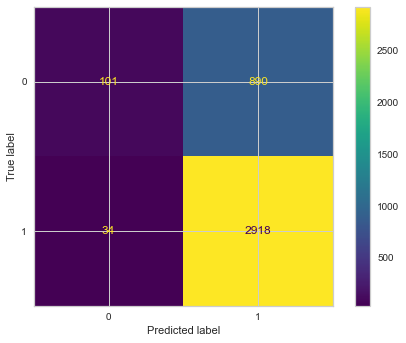

In [67]:
# confusion matrix
matrix = confusion_matrix(Ye_test, y_e_pred)
cmd = ConfusionMatrixDisplay(matrix,display_labels=clf_e.classes_)
cmd.plot()

In [68]:
# metrics
f1 = f1_score(Ye_test, y_e_pred, average = 'weighted',labels=np.unique(y_e_pred))
f2 = fbeta_score(Ye_test, y_e_pred, average='weighted', beta=0.5, zero_division='warn')
prec = precision_score(Ye_test, y_e_pred, average = 'weighted')
acc = accuracy_score(Ye_test, y_e_pred)
recall = recall_score(Ye_test, y_e_pred, average = 'weighted')

print('accuracy: {0}\nprecision: {1}\nrecall: {2}\nf1: {3}\nf0.5: {4}'.format(acc,prec,recall,f1,f2))

accuracy: 0.7656606644686786
precision: 0.7617240273966266
recall: 0.7656606644686786
f1: 0.6914236121427879
f0.5: 0.6835986045315292


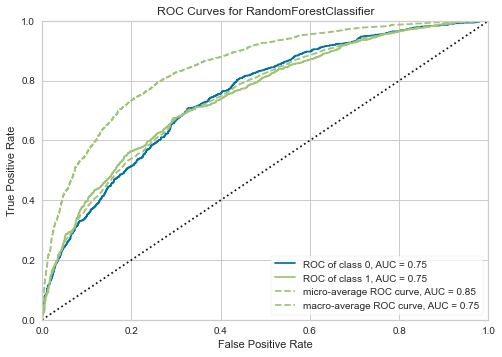

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [69]:
visualizer_clf_e = ROCAUC(clf_e)
visualizer_clf_e.fit(Xe_train,Ye_train)
visualizer_clf_e.score(Xe_test,Ye_test)
visualizer_clf_e.show()

### Full Data RFC

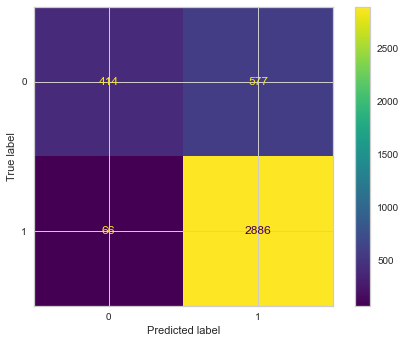

In [70]:
# make confusion matrix 
matrix = confusion_matrix(Yl_test, y_l_pred)
cmd = ConfusionMatrixDisplay(matrix,display_labels=clf_l.classes_)
cmd.plot()

In [71]:
# metrics
f1 = f1_score(Yl_test, y_l_pred, average = 'weighted',labels=np.unique(y_e_pred))
f2 = fbeta_score(Yl_test, y_l_pred, average='weighted', beta=0.5, zero_division='warn')
prec = precision_score(Yl_test, y_l_pred, average = 'weighted')
acc = accuracy_score(Yl_test, y_l_pred)
recall = recall_score(Yl_test, y_l_pred, average = 'weighted')

print('accuracy: {0}\nprecision: {1}\nrecall: {2}\nf1: {3}\nf0.5: {4}'.format(acc,prec,recall,f1,f2))

accuracy: 0.8369261983261476
precision: 0.8406998664333779
recall: 0.8369261983261476
f1: 0.8150966761815737
f0.5: 0.8216204826890656


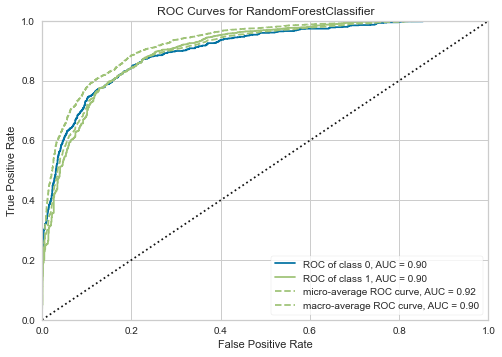

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [72]:
# create ROCAUC plot
visualizer_clf_l = ROCAUC(clf_l)
visualizer_clf_l.fit(Xl_train,Yl_train)
visualizer_clf_l.score(Xl_test,Yl_test)
visualizer_clf_l.show()

In [73]:
feature_imp_e = pd.Series(clf_e.feature_importances_,index=data_model_xe.columns).sort_values(ascending=False)
feature_imp_e

ZIP               0.209755
HEH               0.135763
HS_GRADE          0.131006
EDUCATION_GOAL    0.077254
TAP               0.074810
HS_STATUS         0.071378
MOM_ED            0.058032
ADM_STATUS        0.055971
DAD_ED            0.046383
AWD_LVL           0.046330
HDEG              0.035535
ETHNICITY         0.024453
PELL              0.018377
HAS_KIDS          0.014953
dtype: float64

<AxesSubplot:>

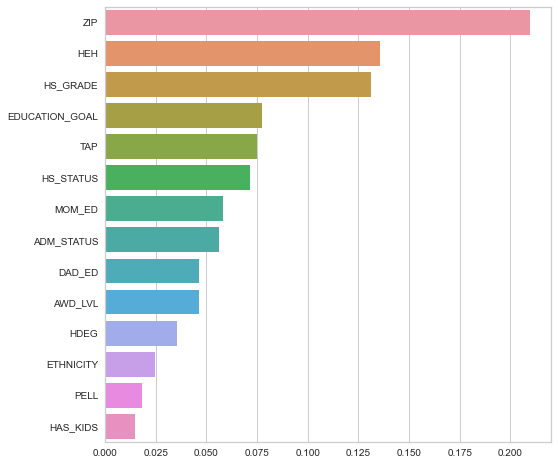

In [80]:
plt.figure(figsize=(8,8))
sns.barplot(x=feature_imp_e, y=feature_imp_e.index)

In [77]:
feature_imp_l = pd.Series(clf_l.feature_importances_,index=data_model_xl.columns).sort_values(ascending=False)
feature_imp_l

FINAL_F             0.095005
FINAL_W             0.077588
T_CRED              0.068390
A_CRED              0.064588
HEH                 0.050475
FINAL_A             0.042245
REPEAT_IND          0.042195
AWD_LVL             0.041653
EDUCATION_GOAL      0.041112
GPA                 0.041010
ADM_STATUS          0.040712
ZIP                 0.036040
SUB_CAMPUS          0.033348
HS_GRADE            0.028595
DAD_ED              0.028468
MOM_ED              0.026916
HS_STATUS           0.026627
TAP                 0.023595
HAS_KIDS            0.021501
ETHNICITY           0.020931
FINAL_B             0.020890
HDEG                0.020332
HOUSING             0.019678
SS_REMEDIAL_CE      0.018112
PELL                0.014251
DISADVANTAGED_ED    0.012854
FINAL_C             0.012754
DISADVANTAGED_EF    0.011444
FINAL_D             0.009305
SS_REMEDIAL         0.007952
FINAL_AU            0.001375
FINAL_S             0.000047
FINAL_NR            0.000012
dtype: float64

<AxesSubplot:>

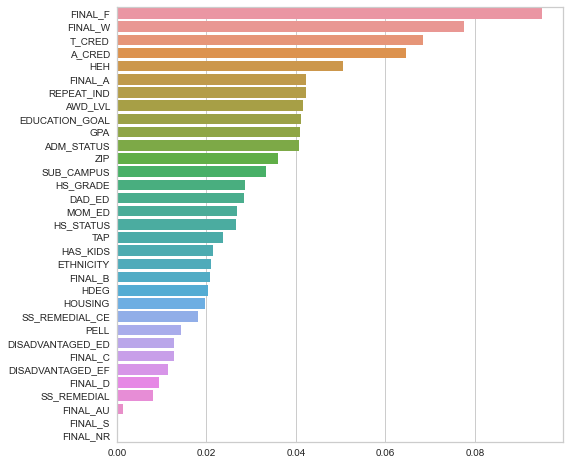

In [79]:
plt.figure(figsize=(8,8))
sns.barplot(x=feature_imp_l, y=feature_imp_l.index)

## Summary

Based on the model results, the ROCAUC results indicate the best fit is probably the RandomForestClassifier with the full set of data. I am unsure of why the model is worse when using the full set of data (in every model except Random Forest) unless there are too many unnecessary fields in the data at this point. I plan on checking the accuracy if I remove some for the final analysis, and finally testing the models with a set of data the model hasn't seen at all where I already know the correct classifications. The performanc here will guide what steps I would recommend moving forward.

## ----====Model Hyperparamter Testing below====----

In [36]:
# list params for multilayer perceptron model
clf_l.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [37]:
# load params to test for random forest model
Forestparam_space = {
    'n_estimators':[25,50,100,200],
    'max_features':['auto','sqrt','log2'],
    'max_depth':[None,10,20,30],
    'min_samples_split':[2,5,10,20,35],
    'min_samples_leaf':[2,5,10,15,20]
    }

In [38]:
# test MLP params
clf = GridSearchCV(clf_l, Forestparam_space, n_jobs=-1, cv=3)
clf.fit(Xl_train, Yl_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(n_estimators=50), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [2, 5, 10, 15, 20],
                         'min_samples_split': [2, 5, 10, 20, 35],
                         'n_estimators': [25, 50, 100, 200]})

In [39]:
# Best parameter set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
0.761 (+/-0.028) for {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 25}
0.764 (+/-0.021) for {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
0.768 (+/-0.019) for {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
0.774 (+/-0.017) for {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
0.766 (+/-0.018) for {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 25}
0.772 (+/-0.016) for {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
0.768 (+/-0.014) for {'max_depth': None, 'max_features': 'auto', 'min_sa